In [1]:
#@title Runtime
use_tpu = False #@param

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
np.random.seed(0)

In [4]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
# labels = np.concatenate(
#     (
#         np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
#         np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
#     ),
#     axis=0,
# )
# weights = np.concatenate(
#     (np.ones((pos_data.shape[0]), dtype=pos_data.dtype), 
#      weights)
# )
# features = np.concatenate((pos_data, neg_data), axis=0)
# pos_data_lengths = np.count_nonzero(pos_data, axis=1)
# neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [5]:
pos_data.shape

(1826, 190)

In [6]:
max_length = pos_data.shape[1]
def encoder(seq, max_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    vec = np.zeros(max_length)
    for i,l in enumerate(seq):
        vec[i] = alphabet.index(l) + 1
    return vec
# sample unlabeled data
def sample_permutations_from_vec(data_lengths, labeled_unlabeled_ratio=0.2, max_sequence_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    with open("../pdb_dist.txt", 'r') as f:
        # the probabilities in this file are sorted based on the alphabet list above
        pdb_dist = f.read().split()
        pdb_dist = [float(item) for item in pdb_dist]
#     unlabeled_seq_lengths = vec_pep_length(positive_data, ohe_vec=False)
#     print(unlabeled_seq_lengths)
    sampled_lengths = []
    for length in data_lengths:
        length_sample_batch = np.ones(int(1/labeled_unlabeled_ratio), dtype=int) * length
        sampled_lengths.append(length_sample_batch)
    sampled_lengths = np.array(sampled_lengths).flatten()
    sampled_sequences = []
    sampled_vecs = []
    for length in tqdm(sampled_lengths):
#         print(length)
    #         random_alphabet_index = np.random.randint(len(alphabet), size=length)
        # sample alphabet index based on weighted amino acid frequencies in pdb
        random_alphabet_index = np.random.choice(len(alphabet), size=length, p=pdb_dist)
        for _ in range(length):
            pep = ''.join([alphabet[m] for m in random_alphabet_index])
        vec_pep = encoder(pep, max_length=max_length)
        # pad zeros
    #     print(ohe_pep.shape)
#         ohe_pep = np.concatenate([ohe_pep, np.zeros((max_sequence_length-ohe_pep.shape[0],20))],axis=0)
        sampled_vecs.append(vec_pep)
        sampled_sequences.append(pep)
#     sampled_vecs = np.array(sampled_vecs)
    return sampled_sequences, sampled_vecs
# ohe_sequence_list = np.concatenate([ohe_sequence_list, np.zeros((190,10))],axis=1)
pos_data_lengths = np.count_nonzero(pos_data, axis=1) + 1
neg_data_lengths = np.count_nonzero(neg_data, axis=1) + 1
labeled_unlabeled_ratio = 0.2
sampled_sequences, sampled_vecs = sample_permutations_from_vec(pos_data_lengths,
                                                               labeled_unlabeled_ratio=0.2, max_sequence_length=max_length)
sampled_vecs = np.array(sampled_vecs)
# X_unlabeled = sampled_vecs
unlabeled_data_lengths = []
for seq in sampled_sequences:
    unlabeled_data_lengths.append(len(seq))

100%|██████████| 9130/9130 [00:00<00:00, 11021.94it/s]


In [7]:
X_positive = pos_data
X_negative = neg_data
X_unlabeled = sampled_vecs
print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Sampled unlabeled data:', len(sampled_sequences))

Positive data: 1826
Negative data: 7490
Sampled unlabeled data: 9130


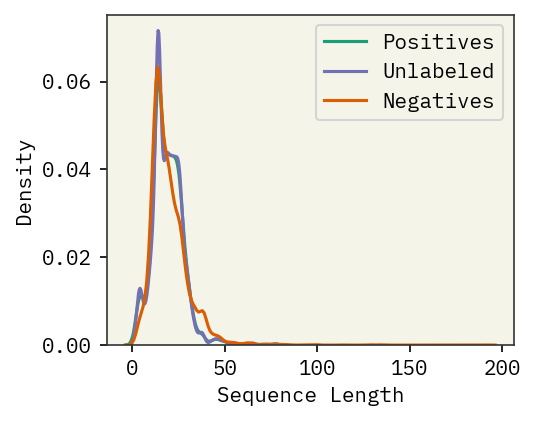

In [8]:
fig, ax = plt.subplots(dpi=150)
sns.kdeplot(pos_data_lengths, ax=ax, label='Positives', color='C0')
ax.set_xlabel('Sequence Length')
# ax.set_title(f'{peptide_label}')
sns.kdeplot(unlabeled_data_lengths, ax=ax, label='Unlabeled', color='C2')
sns.kdeplot(neg_data_lengths, ax=ax, label='Negatives', color='C1')
plt.legend()
plt.savefig(f'length_dist_hemolytic.png', dpi=600, transparent=False, bbox_inches='tight')

In [11]:
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((X_unlabeled.shape[0], 1), dtype=X_unlabeled.dtype),
    ),
    axis=0,
)

features = np.concatenate((pos_data, X_unlabeled), axis=0)

In [16]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(X_positive), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-4,
                drop_rate=0.1
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

In [17]:
if use_tpu:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [18]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
np.random.shuffle(i)
np.random.shuffle(i)
shuffled_labels = labels[i]
shuffled_features = features[i]
data = tf.data.Dataset.from_tensor_slices((shuffled_features, shuffled_labels)).map(lambda x,y: ((x, counts_aa(x)), y))
# data = data.shuffle(config.buffer_size)

# now split into val, test, train and batch
N = len(data)  
L = None#features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
tf.keras.backend.clear_session()
if use_tpu:
  with strategy.scope():
    model = build_model(L)
else:
  model = build_model(L)
#   L = 190
#   model = build_CNN_model(L, reg=0, add_dropout=True)
  decay_epochs = 50
  decay_steps = N  // config.batch_size * decay_epochs
  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
  opt = tf.optimizers.Adam(lr_decayed_fn)
  model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [20]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)

Epoch 1/150
lr = 1e-04
548/548 [==============================] - 25s 23ms/step - loss: 0.1731 - auc: 0.9632 - binary_accuracy: 0.9397 - val_loss: 0.0601 - val_auc: 0.9923 - val_binary_accuracy: 0.9845
Epoch 2/150
lr = 9.9936726e-05
548/548 [==============================] - 10s 17ms/step - loss: 0.0655 - auc: 0.9901 - binary_accuracy: 0.9838 - val_loss: 0.0577 - val_auc: 0.9930 - val_binary_accuracy: 0.9863
Epoch 3/150
lr = 9.9747056e-05
548/548 [==============================] - 10s 17ms/step - loss: 0.0573 - auc: 0.9930 - binary_accuracy: 0.9852 - val_loss: 0.0489 - val_auc: 0.9934 - val_binary_accuracy: 0.9854
Epoch 4/150
lr = 9.94315e-05
548/548 [==============================] - 10s 17ms/step - loss: 0.0545 - auc: 0.9928 - binary_accuracy: 0.9841 - val_loss: 0.0447 - val_auc: 0.9959 - val_binary_accuracy: 0.9845
Epoch 5/150
lr = 9.899082e-05
548/548 [==============================] - 10s 17ms/step - loss: 0.0502 - auc: 0.9922 - binary_accuracy: 0.9854 - val_loss: 0.0415 - val_auc

69/69 [==============================] - 0s 7ms/step - loss: 0.0354 - auc: 0.9990 - binary_accuracy: 0.9900


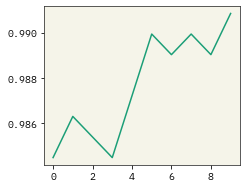

In [21]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate(test_data)
plt.show()